# CIFAR-10 Convolutional neural network

## Exercise - Load data

> **Exercise**: Load the CIFAR-10 data. Normalize the images and split them into train, validation and test sets. Define a `get_batches(X, y, batch_size)` function to generate random X/y batches of size `batch_size` using a Python generator.

In [1]:
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# Load data
with np.load(os.path.join('CIFAR10-60k.npz'), allow_pickle=False) as npz_file:
    cifar = dict(npz_file.items())
    
# Convert pixels into floating point numbers
data = cifar['data'].astype(np.float32)

# Rescale pixel values between -0.5 and 0.5
data = (data - 128) / 255

In [3]:
cifar

{'data': array([[ 59,  62,  63, ..., 123,  92,  72],
        [154, 177, 187, ..., 143, 133, 144],
        [255, 255, 255, ...,  80,  86,  84],
        ...,
        [ 20,  15,  12, ...,  25,  20,  47],
        [ 25,  40,  12, ...,  92, 120,  80],
        [ 73,  78,  75, ...,  27,  26,  26]], dtype=uint8),
 'labels': array([6, 9, 9, ..., 5, 1, 7]),
 'names': array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
        'horse', 'ship', 'truck'], dtype='<U10')}

In [22]:
from sklearn.model_selection import train_test_split

# Split into train and tests sets
X_train, X_test, y_train, y_test = train_test_split(
    # Reshape images (32 by 32 by 3 RGB)
    data.reshape(-1, 32, 32, 3), # single channel (grayscale)
    cifar['labels'],
    test_size=2000, random_state=0
)

# Split again into validation/test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test,
    test_size=1000, random_state=0
)


# Print shape
print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (58000, 32, 32, 3) (58000,)
Valid: (1000, 32, 32, 3) (1000,)
Test: (1000, 32, 32, 3) (1000,)


## Exercise - Create and train a ConvNet

> **Exercise:** Create a convolutional neural network and train it using your batch generator. Evaluate the accuracy on the validation set after each epoch. Test different architectures and parameters. Evaluate your best network on the test set. Save the trained kernel weights of the first convolutional layer in a variable.

In [23]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [27]:
import tensorflow as tf

# Define graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    print('Input',X.shape)

    # Create training placeholder
    training = tf.placeholder(dtype=tf.bool)

    
    # Convolution
    conv = tf.layers.conv2d(
        X, # Input data
        filters=64, # 64 filters
        kernel_size=(5, 5), # Kernel size: 5x5
        strides=(2, 2), # Stride: 2
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv' # Add name
    )
    print('Convolutional 1',conv.shape)
    
    # Get the kernel weights
    with tf.variable_scope('conv', reuse=True):
        conv_kernels = tf.get_variable('kernel')
    
    # Max pooling layer
    pool = tf.layers.max_pooling2d(
        conv, # Convolution output
        pool_size=(2, 2), # Pool size: 2
        strides=(2, 2), # Stride: 2
        padding='SAME' # "same" padding
    )
    print('MaxPool 1',pool.shape)
    
    # Convolution
    conv2 = tf.layers.conv2d(
        pool, # Max pooling output
        filters=64, # 64 filters
        kernel_size=(3, 3), # Kernel size: 3x3
        strides=(1, 1), # Stride: 1
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv2' # Add name
    )
    print('Convolutional 2',conv2.shape)
    # Max pooling layer (2x2, stride: 2)
    pool2 = tf.layers.max_pooling2d(
        conv2, pool_size=(2, 2), strides=(2, 2), padding='SAME')
    
    print('MaxPool 2',pool2.shape)
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)
    print('Flat Ouput',flat_output.shape)
    
    # Apply dropout
    flat_output = tf.layers.dropout(
        flat_output, rate=0.5, seed=0, training=training) 
    
    print('Flat Ouput Dropout',flat_output.shape)
    
    
    # Hidden layer with 256 units (ReLU)
    hidden = tf.layers.dense(
        flat_output, 256, activation=tf.nn.relu,
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    
    print('Last Dense ',hidden.shape)
    
    # Output layer
    logits = tf.layers.dense(
        hidden, 10, # Output units: 10
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    
    print('Output ',logits.shape)
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

Input (?, 32, 32, 3)
Convolutional 1 (?, 16, 16, 64)
MaxPool 1 (?, 8, 8, 64)
Convolutional 2 (?, 8, 8, 64)
MaxPool 2 (?, 4, 4, 64)
Flat Ouput (?, 1024)
Flat Ouput Dropout (?, 1024)
Last Dense  (?, 256)
Output  (?, 10)


In [28]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(15):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_train, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001, # Learning rate
                training: True
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid, 
            training: False
        })
        valid_acc_values.append(valid_acc)
        
        
        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
    
    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()
    
    # Pick a sample image and get 1st conv. activations
    activation_maps = conv.eval(feed_dict={
        X: [X_valid[101]] # Pick one image from the validation set
    })
    
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_test,
        y: y_test,
            training: False
    })
    print('Test accuracy: {:.3f}'.format(test_acc))


Epoch 1 - valid: 0.535 train: 0.435 (mean)
Epoch 2 - valid: 0.646 train: 0.553 (mean)
Epoch 3 - valid: 0.684 train: 0.606 (mean)
Epoch 4 - valid: 0.712 train: 0.645 (mean)
Epoch 5 - valid: 0.732 train: 0.665 (mean)
Epoch 6 - valid: 0.762 train: 0.683 (mean)
Epoch 7 - valid: 0.744 train: 0.694 (mean)
Epoch 8 - valid: 0.758 train: 0.703 (mean)
Epoch 9 - valid: 0.759 train: 0.716 (mean)
Epoch 10 - valid: 0.774 train: 0.725 (mean)
Epoch 11 - valid: 0.777 train: 0.730 (mean)
Epoch 12 - valid: 0.766 train: 0.735 (mean)
Epoch 13 - valid: 0.777 train: 0.742 (mean)
Epoch 14 - valid: 0.777 train: 0.748 (mean)
Epoch 15 - valid: 0.794 train: 0.752 (mean)
Test accuracy: 0.769


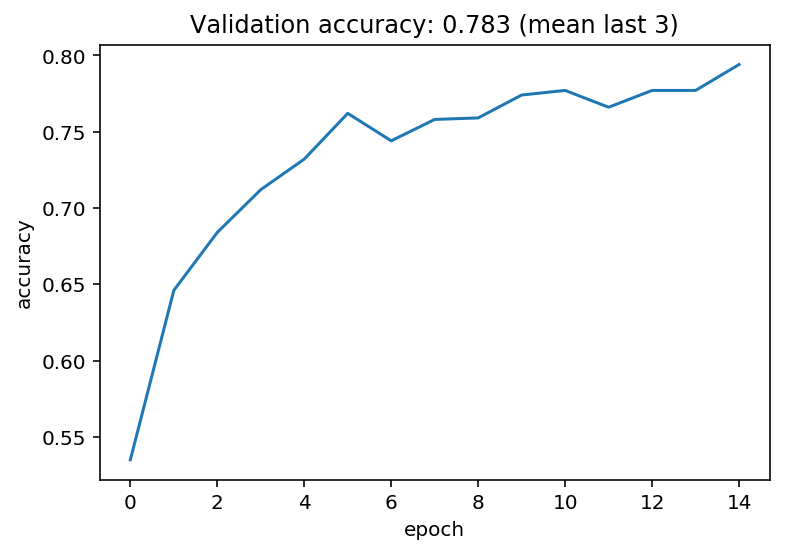

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Exercise - Visualize kernels

> **Exercise**: Plot the kernels from the first convolutional layer with the `imshow()` function.

**Hint**: Remember that the `imshow()` function expects values between 0 and 1 for 3-dimensional arrays.

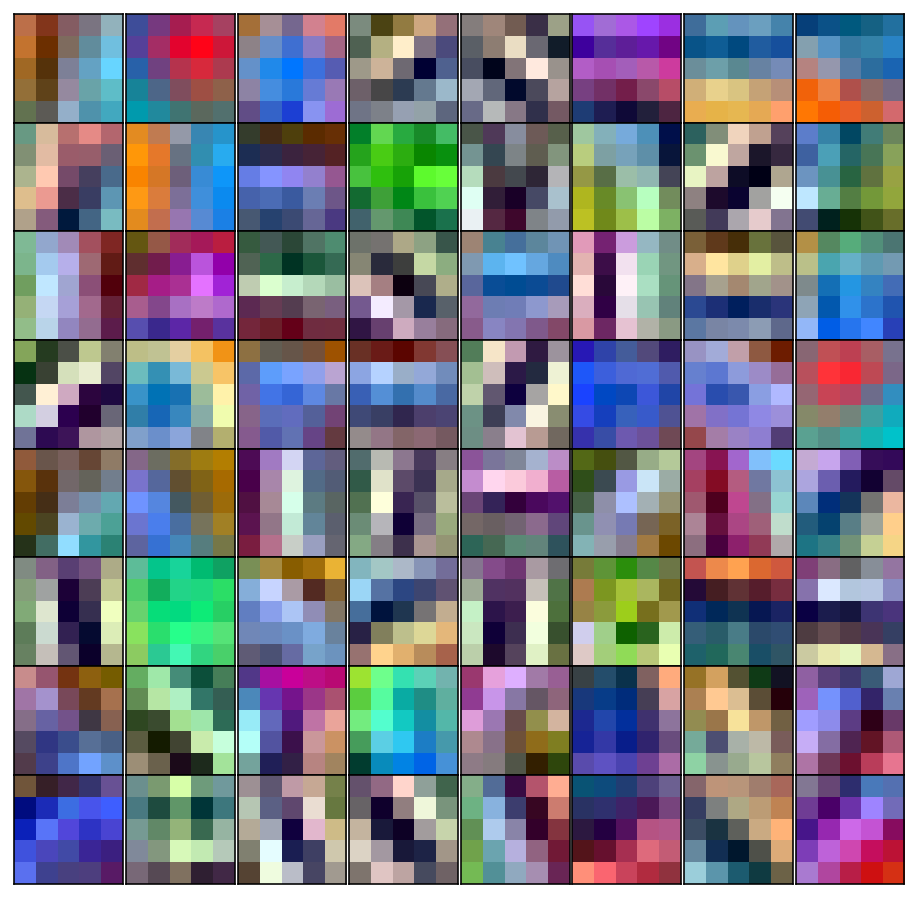

In [34]:
%matplotlib inline

import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 64 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 5x5x3)
    kernel = kernels[:, :, :, i].copy()
    
    # Rescale values between 0 and 1
    kernel -= kernel.min() # Rescale between 0 and max
    kernel /= kernel.max() # Rescale between 0 and 1
    
        
    # Plot kernel with imshow()
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()